In [1]:
%reload_ext autoreload

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from quantum_tools.examples import symbolic_contexts
from quantum_tools.symmetries.workspace import get_contraction_elements
from quantum_tools.config import *
from quantum_tools.visualization.hypergraph import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.hypergraph.hypergraph_transversals import *
from quantum_tools.hypergraph.inequalities import *
from scipy import sparse
import numpy as np
from scipy import io
import os
from functools import reduce
from operator import mul

## Init Config

In [3]:
USE_ORBITS = False
rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))

dimensions = 2
triangle_permutation = utils.get_triangle_permutation(dimensions)

symbolic_context = symbolic_contexts.ABC_444_444
preinjectable_sets = symbolic_context.preinjectable_sets
symbolic_context = SymbolicContext(preinjectable_sets, symbolic_context.outcomes)
infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(preinjectable_sets),
    outcomes=symbolic_context.outcomes
)
b_string = get_preinjectablesets_latex(infl_rvc, preinjectable_sets)
duplication_map = get_duplication_map(b_string)

symbolic_context

SymbolicContext(preinjectable_sets=[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']], [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']], [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']], [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']], [['A1'], ['B3'], ['C4']], [['A1'], ['B4'], ['C2']], [['A2'], ['B1'], ['C4']], [['A2'], ['B2'], ['C2']], [['A3'], ['B3'], ['C3']], [['A3'], ['B4'], ['C1']], [['A4'], ['B1'], ['C3']], [['A4'], ['B2'], ['C1']]], outcomes=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [4]:
row_sum, A, col_sum, contracted_A = get_contraction_elements(symbolic_contexts.ABC_444_444)
if USE_ORBITS:
    target_A = contracted_A
    orbit_contractor = row_sum
    def hg_remove(ant):
        return [ant]
else:
    target_A = A
    orbit_contractor = None
    def hg_remove(ant):
        return duplication_map[b_string[ant]]

16896 16777216
ShiftedBase(shift=0, base=(4194304, 1048576, 262144, 65536, 16384, 4096, 1024, 256, 64, 16, 4, 1))
ShiftedBase(shift=0, base=(1024, 0, 0, 256, 64, 0, 0, 16, 4, 0, 0, 1))
ShiftedBase(shift=4096, base=(1024, 0, 0, 256, 0, 64, 16, 0, 0, 4, 1, 0))
ShiftedBase(shift=8192, base=(0, 1024, 256, 0, 0, 64, 16, 0, 4, 0, 0, 1))
ShiftedBase(shift=12288, base=(0, 1024, 256, 0, 64, 0, 0, 16, 0, 4, 1, 0))
ShiftedBase(shift=16384, base=(16, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1))
ShiftedBase(shift=16448, base=(16, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0))
ShiftedBase(shift=16512, base=(0, 16, 0, 0, 4, 0, 0, 0, 0, 0, 0, 1))
ShiftedBase(shift=16576, base=(0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0, 0))
ShiftedBase(shift=16640, base=(0, 0, 16, 0, 0, 0, 4, 0, 0, 0, 1, 0))
ShiftedBase(shift=16704, base=(0, 0, 16, 0, 0, 0, 0, 4, 1, 0, 0, 0))
ShiftedBase(shift=16768, base=(0, 0, 0, 16, 4, 0, 0, 0, 0, 0, 1, 0))
ShiftedBase(shift=16832, base=(0, 0, 0, 16, 0, 4, 0, 0, 1, 0, 0, 0))
Found 450 row_orbits.
Found 358120 col_o

In [5]:
target_A = sparse.csr_matrix(target_A) # Best format for computing the hypergraphs
target_A_format_cache = {
    'csc': sparse.csc_matrix(target_A),
    'csr': sparse.csr_matrix(target_A),
}

In [8]:
preinjectable_sets

[[['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']],
 [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']],
 [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']],
 [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']],
 [['A1'], ['B3'], ['C4']],
 [['A1'], ['B4'], ['C2']],
 [['A2'], ['B1'], ['C4']],
 [['A2'], ['B2'], ['C2']],
 [['A3'], ['B3'], ['C3']],
 [['A3'], ['B4'], ['C1']],
 [['A4'], ['B1'], ['C3']],
 [['A4'], ['B2'], ['C1']]]

# Optimization Pipeline

1. Params ✓
1. Measurement Operators, States ✓
1. QuantumContext ✓
1. Probability Distribution ✓
1. Marginal Factorized Context Vector ✓
1. Row Sum Contraction ✓
1. Hypergraph Selection Contraction ✓
1. Antecedent, Consequent Selection ✓
1. Inequality Evaluation ✓

## Hypergraph Config (*Plots the hypergraph that is currently being tested against*)

In [7]:
# THIS IS THE GLOBAL ANTECEDENT
g_antecedent = 4*(4**(2*3)) + 0
g_hg_rows, g_hg, g_hg_cols = hyper_graph(target_A, g_antecedent, remove=hg_remove(g_antecedent))
plot_hypergraph(g_hg)

Hypergraph has too many entries > 1e6.


## Actually Compute Transversals

In [172]:
# Studying strat objects
example_strat = TransversalStrat(
    search_type='depth',
    find_up_to=20,
    node_brancher={
        'name': 'greedy',
        'max': 4,
#         'ignore' : ignore,
#         'shuffle' : True,
    }
)

example_strat

In [9]:
def filter_against_target(b, antecedent, hg_rows):
    
    antecedent_value = b[antecedent] # The lhs of the inequality
    marginals_hg_space = b[hg_rows] # The marginals in the space of the hypergraph (values on nodes)
    
    def target_filter(wt):
        """
        wt: The working transversal to consider filtering out
        """
        consequent_values = marginals_hg_space[wt.indices] # The values of the particular consequents
        target = np.sum(consequent_values, axis=0) - antecedent_value # This value *should* be positive if no hardy paradox
#         print(target)
        return target > 0

    return target_filter

In [195]:
# Do the transversal

def do_transversal(fts, batch_size, num_batches):
    starting_size = 0 if fts is None else fts.shape[1]
    ending_size = starting_size + batch_size * num_batches
    i = starting_size
    while i < ending_size:
#         print('i is currently:', i)
        batch_strat = TransversalStrat(
            search_type='depth',
#             breadth_cap=5,
            filter_out=filter_against_target(fritz_dist, g_antecedent, g_hg_rows),
            find_up_to= i + batch_size,
            node_brancher={
#                 'name': 'greedy',
#                 'max': 10,
#                 'ignore' : ignore,
                'shuffle' : True,
            }
        )
        fts = find_transversals(hg, strat=batch_strat, log_wt=False, log_ft=False, fts=fts)
        if fts is None:
            break
        i = fts.shape[1]
    return fts

fts = do_transversal(None, 1, 1)

# minimalized_fts = HGT.make_minimal(hg, fts)
# fts = minimalized_fts
fts is not None

False

## Testing Against Multiple Antecedents

In [129]:
tail_file = open(os.path.join(BULK_DIR, 'transverse_tail.txt'), 'a', 1)

In [113]:
print("cats", file=tail_file)

In [132]:
for i in range(1, 100):
    tail_file.write(str(i) + os.linesep)
# tail_file.flush()

In [44]:
# antecedents = []
# antecedents = list(range(4))
# antecedents = [16384, 16385, 16386, 16387]
# antecedents = [16384]
target_dist = fritz(rvc)
target_b = get_b(target_dist, preinjectable_sets, orbit_contractor) # The values corresponding to the preinjectable marginals
positive_antecdents = np.where(target_b >= 1e-6)[0]

def parallel_weighted_transversals(antecedents):
    import multiprocessing
    pass

def weighted_transversals(antecedents, log=print):
    
    fts_found = []

    for antecedent in antecedents:
        log('Antecedent: {}'.format(antecedent))
        duplicate_antecedents = hg_remove(antecedent)
        larger_positive_consequents = np.where(target_b >= target_b[antecedent])[0]
        log('Number of duplicate antecdents: {}'.format(len(duplicate_antecedents)))
        log('Number of larger possible consequents: {}'.format(len(larger_positive_consequents)))
        remove = np.append(duplicate_antecedents, larger_positive_consequents)
        hg_rows, hg, hg_cols = hyper_graph(target_A_format_cache, antecedent, remove=remove)
        if not transversals_exist(hg):
            print('No transversals to begin with.')
            continue
        log('hg.shape: {}'.format(hg.shape))
        log('density(hg): {}'.format(utils.sparse_density(hg)))

        strat = TransversalStrat(
            search_type='depth',
            # breadth_cap=5,
            filter_out=filter_against_target(target_b, antecedent, hg_rows),
            find_up_to=1,
            node_brancher={
                # 'name': 'greedy',
                # 'max': 10,
                # 'ignore' : ignore,
                # 'shuffle' : True,
            }
        )
        fts = find_transversals(hg, strat=strat, log_wt=False, log_ft=False)
        log('fts: {}'.format(fts))
        if fts is not None:
            fts_found.append({
                'antecedent':antecedent,
                'fts':fts,
                'hg_rows':hg_rows,
                'hg':hg,
                'hg_cols':hg_cols,
            })
    return fts_found

fts_found = weighted_transversals(positive_antecdents[:10])

Antecedent: 0
Number of duplicate antecdents: 4
Number of larger possible consequents: 768
No transversals to begin with.
Antecedent: 16
Number of duplicate antecdents: 4
Number of larger possible consequents: 832


KeyboardInterrupt: 

In [42]:
PROFILE_MIXIN(weighted_transversals)

Antecedent: 0
Number of duplicate antecdents: 4
Number of larger possible consequents: 768
No transversals to begin with.
         39777 function calls (39771 primitive calls) in 4.787 seconds

   Ordered by: cumulative time
   List reduced from 323 to 65 due to restriction <0.2>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.787    4.787 <ipython-input-41-171750524e2b>:6(weighted_transversals)
        1    0.000    0.000    4.623    4.623 /nfs/galaxy/unixhome/tfraser/work/quantum_tools/code/quantum_tools/hypergraph/hypergraph_transversals.py:54(hyper_graph)
      6/3    0.082    0.014    4.621    1.540 /usr/local/anaconda/envs/python3/lib/python3.4/site-packages/scipy/sparse/csr.py:216(__getitem__)
        1    0.000    0.000    4.618    4.618 /nfs/galaxy/unixhome/tfraser/work/quantum_tools/code/quantum_tools/hypergraph/hypergraph_transversals.py:38(hyper_graph_contraction)
        3    0.000    0.000    3.229    1.076 /usr/lo

In [38]:
positive_antecdents[:10]

array([  0,  16,  34,  50,  64,  80,  98, 114, 136, 152])

In [25]:
np.where(target_b >= 1e-6)[0]

array([    0,    16,    34, ..., 16893, 16894, 16895])

In [40]:
fts_found

[]

In [78]:
data = fts_fritz[0]
pprint(data)
print(data['hg_rows'][data['fts'].indices])
Latex(transversal_inequality(data['antecedent'], data['fts'].indices, data['hg_rows'], b_string))

{'antecedent': 16384,
 'fts': <5165x1 sparse matrix of type '<class 'numpy.int16'>'
	with 1 stored elements in Compressed Sparse Column format>,
 'hg': <5165x262144 sparse matrix of type '<class 'numpy.int16'>'
	with 3142592 stored elements in Compressed Sparse Column format>,
 'hg_cols': array([      0,       4,       8, ..., 4191220, 4191224, 4191228], dtype=int32),
 'hg_rows': array([    4,     8,    12, ..., 16893, 16894, 16895])}
[16384]


In [55]:
target_A

<16896x16777216 sparse matrix of type '<class 'numpy.int16'>'
	with 201326592 stored elements in Compressed Sparse Row format>

In [54]:
PROFILE_MIXIN(hyper_graph, target_A_format_cache, 0, [0])

         1787 function calls (1782 primitive calls) in 5.053 seconds

   Ordered by: cumulative time
   List reduced from 79 to 16 due to restriction <0.2>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    5.053    5.053 /nfs/galaxy/unixhome/tfraser/work/quantum_tools/code/quantum_tools/hypergraph/hypergraph_transversals.py:54(hyper_graph)
      6/3    0.066    0.011    5.052    1.684 /usr/local/anaconda/envs/python3/lib/python3.4/site-packages/scipy/sparse/csr.py:216(__getitem__)
        1    0.000    0.000    5.048    5.048 /nfs/galaxy/unixhome/tfraser/work/quantum_tools/code/quantum_tools/hypergraph/hypergraph_transversals.py:38(hyper_graph_contraction)
        3    0.000    0.000    3.680    1.227 /usr/local/anaconda/envs/python3/lib/python3.4/site-packages/scipy/sparse/csr.py:375(_get_submatrix)
        3    3.680    1.227    3.680    1.227 {built-in method get_csr_submatrix}
        3    0.004    0.001    1.303    0.434 /usr/l

## Visualizing Particular Transversals

/usr/local/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


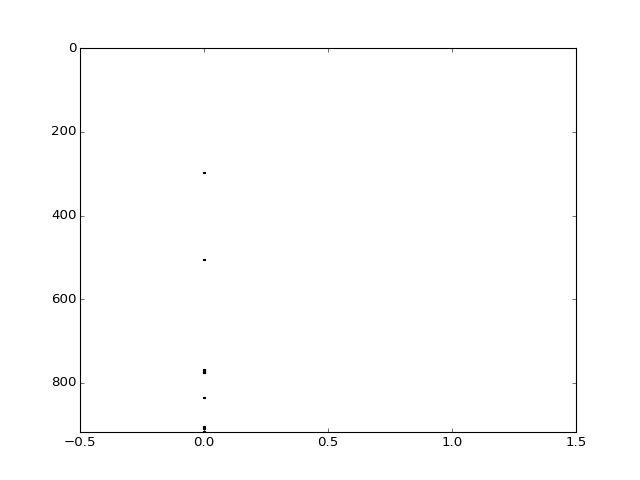

In [188]:
plot_transversals(fts)

/usr/local/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


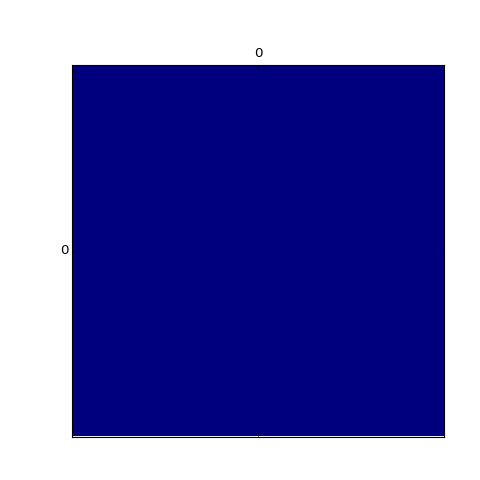

In [189]:
visualize_overlap(fts)

### Storing computed transversals (Evaluated Once)

In [55]:
# utils.save_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_30_depth_5000.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<920x5000 sparse matrix of type '<class 'numpy.int32'>'
	with 151351 stored elements in Compressed Sparse Column format>

In [114]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_16500.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_16500.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<920x16500 sparse matrix of type '<class 'numpy.int32'>'
	with 490799 stored elements in Compressed Sparse Column format>

In [65]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_6150_no_orbits.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_6150_no_orbits.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<917x6150 sparse matrix of type '<class 'numpy.int32'>'
	with 96148 stored elements in Compressed Sparse Column format>

In [96]:
# utils.save_sparse('ABC_444_444_A_fts_ant_0_depth_500_orbits.mtx', fts)
fts_load = utils.load_sparse('ABC_444_444_A_fts_ant_0_depth_500_orbits.mtx')
fts = sparse.csc_matrix(fts_load)
fts

<95x450 sparse matrix of type '<class 'numpy.int32'>'
	with 5404 stored elements in Compressed Sparse Column format>

## Testing against particular distributions

In [12]:
def triangle_test(pd, log):
    targets = pd_to_ineq_target(pd, preinjectable_sets, fts, antecedent, hg_rows, multi=True, orbit_contractor=orbit_contractor)
    if np.any(targets<0):
        print("Found {} Violations".format(log))
    else:
        print("No {} Violations".format(log))
    return pd

In [13]:
from quantum_tools.examples.prob_dists import *

triangle_test(uniform_qdistro(rvc, dimensions), 'Quantum')
triangle_test(uniform_discrete(rvc), 'Correlation')
triangle_test(c4_type(rvc), 'C4-type')
triangle_test(perfect_correlation(rvc), 'Perfect Correlation')
triangle_test(fritz(rvc), 'Fritz')
triangle_test(spekkens(rvc), 'Spekkens')

NameError: name 'fts' is not defined

## Optimizing against a Particular Inequality

In [21]:
from quantum_tools.utilities.job_queuer_async import JobContext

def hom_optimize(transversal_index):
    try:
        ht = fts[:, transversal_index].indices
        hom = HardyOrbitMinimizer(ht, log=False)
        hom.minimize()
        if hom.best_objective_result < 0:
            hom.save_results_to_file(OUTPUT_DIR + "HOM_winner_{0}.txt".format(transversal_index))
        return hom.best_objective_result
    except Exception as e:
        print(e)
        return 0

index_choice = np.random.choice(list(range(fts.shape[1])), size=10)
print([[i] for i in index_choice])
jc = JobContext(hom_optimize, [[i] for i in index_choice])
jc.evaluate()
print(jc.target_results)

[[98], [97], [39], [59], [21], [45], [51], [31], [59], [88]]
JobContext requested 15 cores.
JobContext using 10 cores.
Sub-Job Finished: 10%
Sub-Job Finished: 20%
Sub-Job Finished: 30%
Sub-Job Finished: 40%
Sub-Job Finished: 50%
Sub-Job Finished: 60%
Sub-Job Finished: 70%
Sub-Job Finished: 80%
Sub-Job Finished: 90%
Sub-Job Finished: 100%
[0.0086770806600836858, 0.013366609248564174, 0.0057875823119305902, 0.0093635733369834204, 0.0053649816860059044, 0.0035641655186516765, 0.0094170434131358796, 0.0094170434131358796, 0.0015512539114570822, 0.0017380199580880023]


In [30]:
# TESTING JOBCONTEXT
import time

def f(a,b,c):
    time.sleep(4)
    return a - b * c

def test():
    jc = JobContext(f, [[1,2,3], [2,3,4], [3,4,5], [3, 4, 5], [3, 4, 11]])
    jc.evaluate()
    for result in jc.target_results:
        print(result)
test()

JobContext requested 15 cores.
JobContext using 5 cores.
Sub-Job Finished: 20%
Sub-Job Finished: 40%
Sub-Job Finished: 60%
Sub-Job Finished: 80%
Sub-Job Finished: 100%
-5
-10
-17
-17
-41


In [23]:
# dimensions = 2 # Needed for computational feasibility
hom_transversal = fts[:, min(30, fts.shape[1] - 1)].indices # pick a particular transversal to optimize against
# print(hom_transversal)
hom = HardyOrbitMinimizer(hom_transversal, log=True)
hom.minimize()
# PROFILE_MIXIN(hom.minimize)
# hom.save_results_to_file(OUTPUT_DIR + "HOM_temp.txt")

'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740757'
'Calculated objective:, 1.2828274075'
'Calculated objective:, 1.28282740752'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740754'
'Calculated objective:, 1.28282740754'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740757'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740756'
'Calculated objective:, 1.28282740752'
'Calculated objective:, 1.28282740754'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740752'
'Calculated objective:, 1.28282740756'
'Calculated objective:, 1.28282740754'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740756'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.28282740757'
'Calculated objective:, 1.28282740755'
'Calculated objective:, 1.

In [94]:
conv_transversal = fts[:, -1].indices
con_minimizer = ConvexityMinimizer(conv_transversal, log=True)
con_minimizer.minimize()

'Minimize Step result: 2.576894728510665'
'New Best Objective Result: 2.576894728510665'
'Minimize Step result: 2.0706635015745594'
'New Best Objective Result: 2.0706635015745594'
'Minimize Step result: 1.8464379087909524'
'New Best Objective Result: 1.8464379087909524'
'Minimize Step result: 1.6516935745066168'
'New Best Objective Result: 1.6516935745066168'
'Minimize Step result: 1.5568123741557636'
'New Best Objective Result: 1.5568123741557636'
'Minimize Step result: 1.454567203205219'
'New Best Objective Result: 1.454567203205219'
'Minimize Step result: 1.3529656592139683'
'New Best Objective Result: 1.3529656592139683'
'Minimize Step result: 1.0383235384011689'
'New Best Objective Result: 1.0383235384011689'
'Minimize Step result: 0.8885569362367169'
'New Best Objective Result: 0.8885569362367169'
'Minimize Step result: 0.8630828196011016'
'New Best Objective Result: 0.8630828196011016'
'Minimize Step result: 0.8321599041325842'
'New Best Objective Result: 0.8321599041325842'
'Mi

In [86]:
print(con_minimizer.best_objective_result)
print(con_minimizer.best_context)

0.000700675778398
=== ProbDist ===
RandomVariableCollection
3 Random Variables:
Outcomes: 64 = 4^3
A -> [0, 1, 2, 3]
B -> [0, 1, 2, 3]
C -> [0, 1, 2, 3]
64 Achievable outcomes.
{outcome} -> {probability}
[0, 0, 0] -> 4.2127877521906056e-05
[0, 0, 1] -> 2.7075630677110535e-07
[0, 0, 2] -> 3.832318635032471e-07
[0, 0, 3] -> 3.7174694457427755e-07
[0, 1, 0] -> 0.19780322316066407
[0, 1, 1] -> 0.0006998994700550562
[0, 1, 2] -> 9.83560942199544e-10
[0, 1, 3] -> 7.1248451561328265e-06
[0, 2, 0] -> 7.121367540090533e-05
[0, 2, 1] -> 8.442785976501646e-09
[0, 2, 2] -> 2.093904140030005e-08
[0, 2, 3] -> 4.576508231665934e-12
[0, 3, 0] -> 0.19780262729311895
[0, 3, 1] -> 0.004776826064602654
[0, 3, 2] -> 2.6591340009510706e-13
[0, 3, 3] -> 2.0126268145061402e-05
[1, 0, 0] -> 2.2864350227506704e-09
[1, 0, 1] -> 2.6508270096819307e-06
[1, 0, 2] -> 1.3671178448164577e-06
[1, 0, 3] -> 2.4043019529283347e-10
[1, 1, 0] -> 1.0007616385152933e-06
[1, 1, 1] -> 7.185718212574238e-06
[1, 1, 2] -> 5.877124

In [30]:
import numpy as np
from quantum_tools.optimizers.minimizer import Minimizer
from quantum_tools.utilities import utils
from quantum_tools.config import *
from quantum_tools.contexts.measurement import Measurement
from quantum_tools.contexts.state import State
from quantum_tools.statistics.variable import RandomVariableCollection
from quantum_tools.inflation import marginal_equality
from quantum_tools.examples import symbolic_contexts
from quantum_tools.contexts.quantum_context import QuantumContext, QuantumProbDist, QuantumProbDistOptimized

class HardyOrbitMinimizer(Minimizer):

    def __init__(self, transversal_indices, log=False):
        Minimizer.__init__(self, [32,32,32,16,16,16])
        self.local_log = log
        self.permutation = triangle_permutation
        self.random_variables = rvc
        self.tolerance = 1e-3
        self.max_evals = 1
        self.step_size = 100
        self.transversal_indices = transversal_indices
#         self.preinjectable_sets = 
#         self.orbit_contractor = row_sum
#         self.antecedent = antecedent
#         self.transversal_indicies = transversal_indicies # pick a particular transversal to optimize against
#         self.hg_rows = hg_rows

    def initial_guess(self):
        initial_guess = np.random.normal(scale=10.0, size=self.mem_size)
        return initial_guess

    def get_context(self, param):
        pA, pB, pC, prhoAB, prhoBC, prhoAC = self.mem_slots
        A = Measurement.Strats.Param.pvms(param[pA])
        B = Measurement.Strats.Param.pvms(param[pB])
        C = Measurement.Strats.Param.pvms(param[pC])
        rhoAB = State.Strats.Param.dm(param[prhoAB])
        rhoBC = State.Strats.Param.dm(param[prhoBC])
        rhoAC = State.Strats.Param.dm(param[prhoAC])

        qc = QuantumContext(
            random_variables=self.random_variables,
            measurements=(A,B,C),
            states=(rhoAB,rhoBC,rhoAC),
            permutation=self.permutation,
        )
        return qc

    def objective(self, param):
        qc = self.get_context(param)
        pd = QuantumProbDistOptimized(qc)

        target = pd_to_ineq_target(pd, self.transversal_indices)
        self.log("Calculated objective:", target)
        return target

In [27]:
import numpy as np
from quantum_tools.optimizers.minimizer import Minimizer
from quantum_tools.utilities import utils
from quantum_tools.config import *

class ConvexityMinimizer(Minimizer):

    def __init__(self, transversal_indices, log=False):
        Minimizer.__init__(self, [len(rvc.outcome_space)])
        self.local_log = log
        self.random_variables = rvc
        self.transversal_indices = transversal_indices
        self.tolerance = 1e-3
        self.max_evals = 2
        self.step_size = 100

    def initial_guess(self):
        initial_guess = np.random.normal(scale=10.0, size=self.mem_size)
        return initial_guess

    def get_context(self, param):
        pAll = self.mem_slots
        param_shaped = param[pAll].reshape(self.random_variables.outcome_space.get_input_base())
        param_shaped = np.cos(param_shaped, param_shaped)**2
        param_shaped /= np.sum(param_shaped)
        support = param_shaped
        
        return ProbDist(self.random_variables, support)

    def objective(self, param):
        pd = self.get_context(param)

        target = pd_to_ineq_target(pd, self.transversal_indices)
#         if partial_log(.01):
#             self.log("Calculated objective:", target)
        return target